# 필요한 도구  Import

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import random
import matplotlib.pyplot as plt

# GPU 사용 및 랜덤시트 고정
- 랜덤시트 고정했기 때문에 모두 동일한 결과 나옵니다.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# 파라미터 설정
- epoch 맡으신 분은 여기있는 숫자 조정하시면 됩니다.

In [3]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

# MNIST 데이터 불러오기
- 총 60,000개입니다.
- batch size가 100이라 총 600개의 batch가 만들어집니다.

In [4]:
mnist_train = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)


# 데이터로더 불러오기

In [5]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)
test_subset = torch.utils.data.Subset(mnist_test, indices=random.sample(range(len(mnist_test)), 500))
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# CNN 모델 설계
- kernel크기, stride, pooling 맡으신분들은 여기서 조정하시면 됩니다.
- kernel, pooling 맡으신 분들은 크기 조정하시면 최종 결과물의 크기도 달라집니다. 변형된 크기에 맞춰 신경망(fc) 입력 크기 조정해주세요~

In [6]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))


        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        return out


---

# 모델 학습 및 평가
- 모델 객체 생성 및 GPU 사용
- 손실함수, 옵티마이저 정의

[Epoch: 1] Train Loss: 0.2256, Test Loss: 0.0635
[Epoch: 2] Train Loss: 0.0617, Test Loss: 0.0395
[Epoch: 3] Train Loss: 0.0463, Test Loss: 0.0274
[Epoch: 4] Train Loss: 0.0358, Test Loss: 0.0299
[Epoch: 5] Train Loss: 0.0301, Test Loss: 0.0294
[Epoch: 6] Train Loss: 0.0252, Test Loss: 0.0177
[Epoch: 7] Train Loss: 0.0218, Test Loss: 0.0271
[Epoch: 8] Train Loss: 0.0179, Test Loss: 0.0247
[Epoch: 9] Train Loss: 0.0154, Test Loss: 0.0142
[Epoch: 10] Train Loss: 0.0134, Test Loss: 0.0195
[Epoch: 11] Train Loss: 0.0114, Test Loss: 0.0190
[Epoch: 12] Train Loss: 0.0095, Test Loss: 0.0266
[Epoch: 13] Train Loss: 0.0088, Test Loss: 0.0391
[Epoch: 14] Train Loss: 0.0059, Test Loss: 0.0186
[Epoch: 15] Train Loss: 0.0078, Test Loss: 0.0327


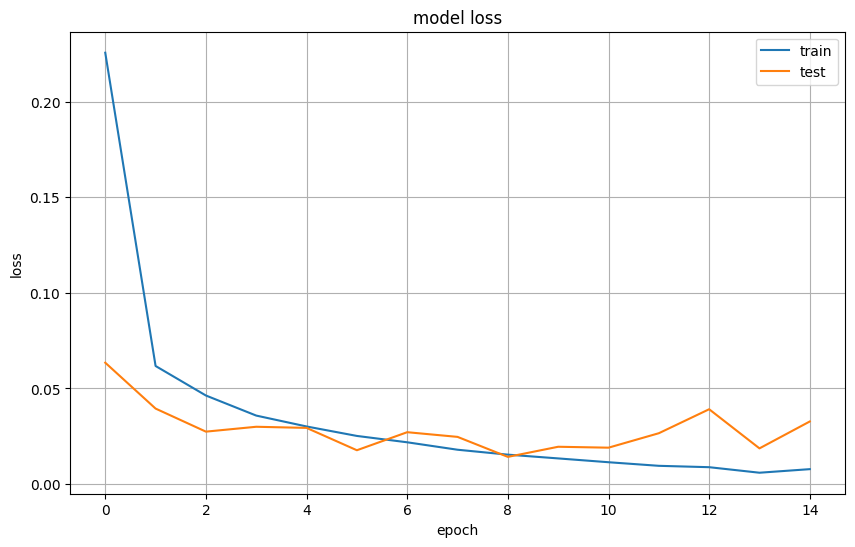

In [11]:
# CNN 모델 정의
model = CNN().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_batch = len(data_loader)

# 손실값을 저장할 리스트 생성
train_losses = []
test_losses = []

for epoch in range(training_epochs):
    # 학습 데이터 손실 계산
    train_loss = 0
    for X, Y in data_loader:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()
        train_loss += cost / total_batch
    train_losses.append(train_loss.item())

    # 테스트 데이터 손실 계산
    with torch.no_grad():
        test_loss = 0
        for X, Y in test_loader:  # test_loader는 500개의 테스트 데이터로 구성
            X, Y = X.to(device), Y.to(device)
            pred = model(X)
            test_loss += criterion(pred, Y) / len(test_loader)
        test_losses.append(test_loss.item())

    print(f'[Epoch: {epoch+1}] Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# 손실 그래프 출력
plt.figure(figsize=(10, 6))
plt.plot(range(training_epochs), train_losses, label='train')
plt.plot(range(training_epochs), test_losses, label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('model loss')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# 학습을 진행하지 않을 것이므로 torch.no_grad() 사용
with torch.no_grad():
    # 테스트 데이터를 모델에 입력하기 위한 준비
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)  # 테스트 데이터셋의 크기를 맞추고, 연산을 위한 장치로 이동
    Y_test = mnist_test.test_labels.to(device)  # 테스트 데이터셋의 레이블을 연산을 위한 장치로 이동

    # 모델 예측 수행
    prediction = model(X_test)  # 테스트 데이터에 대해 모델이 예측한 결과값

    # 예측 결과와 실제 레이블 비교
    correct_prediction = torch.argmax(prediction, 1) == Y_test  # 예측된 클래스와 실제 레이블이 일치하는지 확인

    # 정확도 계산
    accuracy = correct_prediction.float().mean()  # 정확도를 계산하기 위해 일치하는 예측의 평균을 구함
    print('Accuracy:', accuracy.item())  # 정확도를 출력


Accuracy: 0.9863999485969543


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
